# NETWORK TRAFFIC ANOMALY DETECTION USING MACHINE LEARNING

#### Rayen NAIT SLIMANE - Masters Student ISIMA INP

The exponential growth of network traffic and reliance on cloud services necessitate Intrusion Detection Systems (IDS) that can robustly identify not only known but also novel attack types. This notebook evaluates the generalization capabilities of two machine learning models Multi-Layer Perceptron, Random Forest on the CICIDS2017 dataset to determine the optimal supervised paradigm for effective anomaly detection.

[CICIDS2017\_Dataset](https://www.unb.ca/cic/datasets/ids-2017.html)

## 1. Exploration
### 1.1 Data Loading

In [52]:
import pandas as pd
import random

# List all CSV files
files = [
    "MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    "MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "MachineLearningCSV/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv",
    "MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "MachineLearningCSV/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv",
    "MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv"
]

# Load 10000 random rows from 8 files (80000 rows total)
# Avoids loading entire csv files and causing memory issues

random.seed(42)

dfs = []
for file in files:
    try:
        n_rows = sum(1 for _ in open(file)) - 1
        skip_rows = sorted(random.sample(range(1, n_rows + 1), max(0, n_rows - 10000)))
        df_temp = pd.read_csv(file, skiprows=skip_rows)
        dfs.append(df_temp)
    except:
        print(f"Skipping {file}")

df = pd.concat(dfs, ignore_index=True)

In [53]:
# Preview the data frame

print("COLUMN INFO:")
print(df.info())

print("\nATTACK TYPES:")
print(df[' Label'].value_counts())

non_benign = len(df) - df[' Label'].value_counts()['BENIGN']
print(f"\nNON BENIGN COUNT: {non_benign}")


COLUMN INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 79 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0    Destination Port             80000 non-null  int64  
 1    Flow Duration                80000 non-null  int64  
 2    Total Fwd Packets            80000 non-null  int64  
 3    Total Backward Packets       80000 non-null  int64  
 4   Total Length of Fwd Packets   80000 non-null  int64  
 5    Total Length of Bwd Packets  80000 non-null  int64  
 6    Fwd Packet Length Max        80000 non-null  int64  
 7    Fwd Packet Length Min        80000 non-null  int64  
 8    Fwd Packet Length Mean       80000 non-null  float64
 9    Fwd Packet Length Std        80000 non-null  float64
 10  Bwd Packet Length Max         80000 non-null  int64  
 11   Bwd Packet Length Min        80000 non-null  int64  
 12   Bwd Packet Length Mean       80000 non-null  f

### 1.2 Missing Values

In [37]:
# Calculate the total number of rows
total_rows = len(df)

# Calculate the count and percentage of missing values per column
missing_info = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percentage (%)': (df.isnull().sum() / total_rows) * 100
})

# Filter and display only columns with missing data, sorted by percentage
print(missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Percentage (%)', ascending=False))


              Missing Count  Missing Percentage (%)
Flow Bytes/s             23                 0.02875


### 1.3 Vastly Different Scales

In [38]:
# Display min, max, and std for all numerical features
print(df.describe().T[['min', 'max', 'std']])

                             min          max           std
 Destination Port            0.0      65531.0  1.812202e+04
 Flow Duration              -1.0  119999646.0  3.175915e+07
 Total Fwd Packets           1.0      19004.0  1.240030e+02
 Total Backward Packets      0.0      28926.0  1.844056e+02
Total Length of Fwd Packets  0.0     218062.0  3.090443e+03
...                          ...          ...           ...
 Active Min                  0.0   34000000.0  4.736273e+05
Idle Mean                    0.0  120000000.0  1.978632e+07
 Idle Std                    0.0   75300000.0  5.174695e+06
 Idle Max                    0.0  120000000.0  2.088970e+07
 Idle Min                    0.0  120000000.0  1.935015e+07

[78 rows x 3 columns]


### 1.4 Highly Correlated Features

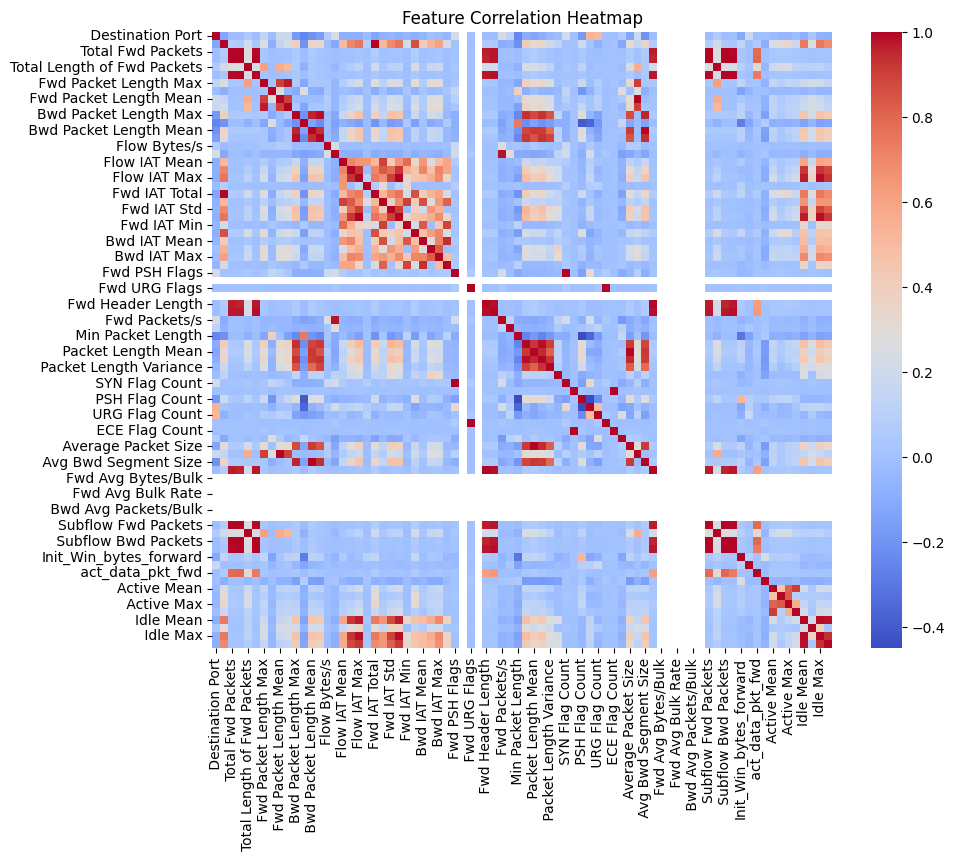

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for only numerical data
corr_matrix = df.select_dtypes(include=['number']).corr()

plt.figure(figsize=(10, 8))

# Use a heatmap to visualize
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False) 
plt.title('Feature Correlation Heatmap')
plt.show()

## 2. Preprocessing
### 2.1 Clean data

In [42]:
df = df.replace([float('inf'), float('-inf')], float('nan'))
df = df.dropna()


y = df[' Label']
X = df.drop(' Label', axis=1)
X = X.select_dtypes(include=['number'])

# Remove Web Attack � Sql Injection since it has only 1 member (row)
mask = y != 'Web Attack � Sql Injection'
X = X[mask]
y = y[mask]

### 2.2 Split data

In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

# Stratify ensures all classes appear proportionally in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 3. Model Architecture & Training
### 3.1 Multi-Layer Perceptron Model Classification

In [44]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

### 3.2 Random Forest Model Classification

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 5. Results & Evaluation

In [47]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import warnings

# Predictions
y_pred_mlp = mlp.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Basic accuracy
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"MLP Accuracy: {mlp_accuracy:.4f}")
print(f"RF Accuracy: {rf_accuracy:.4f}\n")

# Classification reports with zero_division parameter
print("="*50)
print("MLP Classification Report:")
print("="*50)
print(classification_report(y_test, y_pred_mlp, target_names=le.classes_, zero_division=0))

print("="*50)
print("RF Classification Report:")
print("="*50)
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

# Confusion matrices
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("\nMLP Confusion Matrix:")
print(cm_mlp)
print("\nRF Confusion Matrix:")
print(cm_rf)

# Optional: Check which classes weren't predicted
print("\n" + "="*50)
print("Prediction Coverage:")
print("="*50)
print(f"Classes in test set: {len(np.unique(y_test))}")
print(f"Classes predicted by MLP: {len(np.unique(y_pred_mlp))}")
print(f"Classes predicted by RF: {len(np.unique(y_pred_rf))}")

# Show unpredicted classes
unpredicted_mlp = set(y_test) - set(y_pred_mlp)
unpredicted_rf = set(y_test) - set(y_pred_rf)
if unpredicted_mlp:
    print(f"\nClasses MLP failed to predict: {[le.classes_[i] for i in unpredicted_mlp]}")
if unpredicted_rf:
    print(f"Classes RF failed to predict: {[le.classes_[i] for i in unpredicted_rf]}")

MLP Accuracy: 0.9076
RF Accuracy: 0.9930

MLP Classification Report:
                          precision    recall  f1-score   support

                  BENIGN       0.91      0.98      0.95     12884
                     Bot       0.55      0.30      0.39        20
                    DDoS       0.99      0.46      0.63      1132
           DoS GoldenEye       0.17      0.04      0.06        28
                DoS Hulk       0.93      0.34      0.49       677
        DoS Slowhttptest       0.25      0.12      0.16        17
           DoS slowloris       0.00      0.00      0.00        17
             FTP-Patator       0.11      0.49      0.18        37
                PortScan       0.94      0.99      0.96      1123
             SSH-Patator       0.60      0.50      0.55        24
Web Attack � Brute Force       0.00      0.00      0.00        21
        Web Attack � XSS       0.00      0.00      0.00         9

                accuracy                           0.91     15989
     

# 6. Conclusions

**Performance Comparison:**
Random Forest significantly outperforms MLP with 99.3% accuracy compared to 90.8%. MLP struggles with major attacks like DDoS (46% recall) and DoS Hulk (34% recall), incorrectly labeling hundreds of attacks as normal traffic. RF achieves excellent results across most categories, consistently detecting over 97% of common attacks.

**Dataset Limitations:**
Despite using 80,000 samples, rare attacks remain problematic. Web Attack types (21-44 samples) and Bot attacks (103 samples) are vastly outnumbered by 64,459 BENIGN samples. Both models fail completely on Web Attacks (0% detection), and RF only catches 5% of Bot attacks. More balanced data or techniques like class weighting are needed for reliable rare attack detection.
